In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import energyflow as ef
import energyflow.archs

sys.path.append("../")
import omnifold
import modplot
# import ibu
# import uproot


2024-07-11 17:55:48.092195: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'

In [3]:
names = ['pdg','pid_gen','pid_rec','cz_rec','cz_numu_rec','e_rec','e_numu_rec','cz_gen','e_gen','type','weight']

In [4]:
input_data = pd.read_csv("/Users/wingyanma/Documents/GitHub/pisa/pisa_examples/resources/events/J23_all_events.csv",
                         names=names, header=0, index_col=[0])


In [5]:
input_data

,pdg,pid_gen,pid_rec,cz_rec,cz_numu_rec,e_rec,e_numu_rec,cz_gen,e_gen,type,weight
0,14,numu,numu,0.494961,0.590685,0.853201,1.157009,0.855655,3.841143,1,1
1,14,numu,numu,0.274824,0.141403,4.300221,4.784906,0.113431,4.579452,1,1
2,14,numu,numu,0.242091,0.154218,2.578972,2.529813,0.404237,2.226287,1,1
3,14,numu,numu,-0.406088,-0.440340,2.419158,2.477218,-0.807746,2.606570,1,1
4,14,numu,numubar,0.597770,0.653224,3.485928,3.430741,0.187372,3.119193,1,1
...,...,...,...,...,...,...,...,...,...,...,...
94970,14,nc,nc,0.357342,0.369064,1.798511,2.144140,0.681854,4.422088,0,1
94971,-12,nc,nc,-0.290957,-0.492486,2.885988,3.517319,0.044246,5.999827,0,1
94972,12,nc,nc,-0.570296,-0.735233,1.708040,1.500363,-0.395516,2.657809,0,1
94973,14,nc,nc,-0.072436,-0.063474,4.060598,4.322109,-0.026144,7.631851,0,1


In [6]:
new_label = {"pid_gen": {"numu": 0, "numubar": 1, "nue": 2, "nuebar": 3, "nc": 4}}
input_data.replace(new_label , inplace = True)
new_label = {"pid_rec": {"numu": 0, "numubar": 1, "nue": 2, "nuebar": 3, "nc": 4}}
input_data.replace(new_label , inplace = True)
theta_rec = np.arccos(input_data['cz_rec'])/np.pi*180.
theta_gen = np.arccos(input_data['cz_gen'])/np.pi*180.

input_data['theta_rec'] = theta_rec
input_data['theta_gen'] = theta_gen

In [7]:
min(input_data['theta_gen']), max(input_data['theta_gen'])

(0.4546659936491172, 179.73634887223196)

In [56]:
sim = input_data.sample(frac=0.6, random_state=1)
idx = sim.index
data = input_data[~input_data.index.isin(idx)]

datasets = {'simul':sim,'data':data}

## Specifying the Unfolding Problem

OmniFold requires particle-level event generators as well as a faithful simulation of the detector, both are in HS. 

In [57]:
# choose what is MC(MonteCarlo/simulations) and Data in this context
synthetic, nature = datasets['simul'], datasets['data']

We also have to specify `itnum`: how many iterations of the unfolding procedure we want to do.

**Customize**: Change `itnum` to your desired number of unfolding iterations.

In [58]:
# how many iterations of the unfolding process
itnum = 3

There are three flavors of OmniFold. In order of increasing sophistication, they are:
* **UniFold**: Represent the jet as a single observable.
* **MultiFold**: Represent the jet as multiple observables.
* **OmniFold**: Represent the jet as a set of particles.

i am not shure if this is omnifold or multifold or what is the difference

In [137]:
# Phase space of the correction
# obs_multifold = ['pid', 'theta', 'e'] 
obs_multifold = ['theta', 'e'] 

The observables are already computed in the samples. We will read them in as an observable dictionary `obs` and also specify histogram style information.

**Customize**: Add entries to `obs` to define your own observables to be used in MultiFold or to see the unfolding performance on them.

In [152]:
# a dictionary to hold information about the observables
obs = {}

# obs.setdefault('pid', {}).update({
#     'func': lambda dset, ptype: dset['pid_' + ptype],
#     'nbins_det': 5, 'nbins_mc': 5,
#     'xlim': (-0.5, 4.5), 'ylim': (0, 1.5),
#     'xlabel': r'PID', 'symbol': r'PID',
#     'ylabel': r'Normalized Cross Section ',
#     'stamp_xy': (0.425, 0.65),
# })

obs.setdefault('theta', {}).update({
    'func': lambda dset, ptype: dset['theta_'+ ptype],
    'nbins_det': 18, 'nbins_mc': 18,
    'xlim': (0., 180.), 'ylim': (0, 0.02),
#     'xlabel': r'$\nu$[$GeV$]', 'symbol': r'$\nu$',
    'xlabel': r'$\theta$', 'symbol': r'$\theta$',
#     'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.42, 0.65),
})

# obs.setdefault('cz', {}).update({
#     'func': lambda dset, ptype: dset['cz_'+ ptype],
#     'nbins_det': 20, 'nbins_mc': 20,
#     'xlim': (-1., 1.), 'ylim': (0., 1.),
# #     'xlabel': r'$\nu$[$GeV$]', 'symbol': r'$\nu$',
#     'xlabel': r'cos$\theta$', 'symbol': r'cos$\theta$',
# #     'ylabel': r'Normalized Cross Section',
#     'stamp_xy': (0.42, 0.65),
# })

obs.setdefault('e', {}).update({ 
    'func': lambda dset, ptype: dset['e_' + ptype],
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0., 20.), 'ylim': (0, 0.5),
#     'xlabel': r'$Pt^2$[GeV]', 'symbol': r'$Pt^2$',
    'xlabel': r'$E$[GeV]', 'symbol': r'$E$',
#     'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper right', 'legend_ncol': 1,
})


# additional histogram and plot style information
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '-', 'color': 'blue', 'lw': 1.15, 'label': 'Sim.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '``Data\"'}
# ibu_style = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'gray', 'zorder': 1}
omnifold_style = {'ls': 'dashed', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}

Now all that remains is to get the values of the specified observables and compute the histograms with the specified binnings. As an unfolding benchmark, we also obtain the unfolding results of Iterative Bayesian Unfolding (IBU) as implemented in `ibu.py`. The following cell takes care of all of these aspects.

In [153]:
# calculate quantities to be stored in obs
for obkey,ob in obs.items():
    
    # Add the array with the data to the las dictionary
    # calculate observable for GEN, (REC)SIM, DATA, and TRUE
    ob['genobs'], ob['simobs'] = ob['func'](synthetic, 'gen'), ob['func'](synthetic, 'rec')
    ob['truthobs'], ob['dataobs'] = ob['func'](nature, 'gen'), ob['func'](nature, 'rec')

    # setup bins
    # ob['rec/det or gen/mc'] = np.linspace(min val, max val, nbins + 1)
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    # = np.linspace(bin-array except the last number, bin-array except the first number) all array vals divided by 2
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    # Second val - first val = width
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]
    
    # get the histograms of GEN, DATA, and TRUTH level observables
    #  np.histogram(data Array , binning array, density=True(this normalize the histogram))
    # the [0] is to select the first return object of the method,which is the number of event per bin
    # in this case normalized beacause density=True
#     ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'], density=True)[0]
#     ob['data_hist'] = np.histogram(ob['dataobs'], bins=ob['bins_det'], density=True)[0]
    ob['simobs_hist'] = np.histogram(ob['simobs'], bins=ob['bins_mc'], density=True)[0]
    ob['truth_hist'] = np.histogram(ob['truthobs'], bins=ob['bins_det'], density=True)[0]
    # modplot.calc_hist(Data array, binning array,  this just select if the bigger or equal of the binning selection 
    # goes in the right or in the left)
    # [:2] this returns the first 2 object created by the method that  is a histgram and the errors 
#     ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'],
#                                                                bins=ob['bins_mc'], density=True)[:2]
    ob['data_hist'], ob['data_hist_unc'] = modplot.calc_hist(ob['dataobs'],
                                                               bins=ob['bins_mc'], density=True)[:2]

    

    # compute (and normalize) the response matrix between GEN and SIM
#     ob['response'] = np.histogram2d(ob['simobs'], ob['genobs'], bins=(ob['bins_det'], ob['bins_mc']))[0]
#     ob['response'] /= (ob['response'].sum(axis=0) + 10**-50)
#     # perform iterative Bayesian unfolding
#     ob['ibu_phis'] = ibu.ibu(ob['data_hist'], ob['response'], ob['genobs_hist'], 
#                          ob['binwidth_det'], ob['binwidth_mc'], it=itnum)
#     ob['ibu_phi_unc'] = ibu.ibu_unc(ob, it=itnum, nresamples=25)
    
    print('Done with', obkey)

Done with theta
Done with e


In [154]:
# How many layers and neurons for each layer to use in the deep learning
model_layer_sizes = [100, 100]
# model_layer_sizes = [100, 100, 100] # use this for the full network size

# set up the array of data/simulation detector-level observables
# X are the features/variables
## reweight gen to truth
X_det = np.asarray([np.concatenate((obs[obkey]['truthobs'], obs[obkey]['genobs'])) for obkey in obs_multifold]).T
# Y are labels(variable that you want to know)/ weights
Y_det = ef.utils.to_categorical(np.concatenate((np.ones(len(obs['e']['truthobs'])), 
                                                np.zeros(len(obs['e']['genobs'])))))

# set up the array of generation particle-level observables
X_gen = np.asarray([np.concatenate((obs[obkey]['simobs'], obs[obkey]['simobs'])) for obkey in obs_multifold]).T
Y_gen = ef.utils.to_categorical(np.concatenate((np.ones(len(obs['e']['simobs'])), 
                                                np.zeros(len(obs['e']['simobs'])))))

# standardize the inputs (variables- mean)/standar deviation
X_det = (X_det - np.mean(X_det, axis=0))/np.std(X_det, axis=0)
X_gen = (X_gen - np.mean(X_gen, axis=0))/np.std(X_gen, axis=0)

# Specify the training parameters
# model parameters for the Step 1 network
det_args = {'input_dim': len(obs_multifold), 'dense_sizes': model_layer_sizes,
            'patience': 10, 'filepath': 'Step1_{}', 'save_weights_only': False, 
            'modelcheck_opts': {'save_best_only': True, 'verbose': 1}}

# model parameters for the Step 2 network
mc_args = {'input_dim': len(obs_multifold), 'dense_sizes': model_layer_sizes, 
           'patience': 10, 'filepath': 'Step2_{}', 'save_weights_only': False, 
           'modelcheck_opts': {'save_best_only': True, 'verbose': 1}}

# general training parameters
# Batch_size is the number of examples used to train the data at same time(it used all but not all at same time)
# epoch i the number of steam
# i am not sure about the last two thing hahha
fitargs = {'batch_size': 500, 'epochs': 2, 'verbose': 1}
#fitargs = {'batch_size': 500, 'epochs': 100, 'verbose': 1} # use this for a full training

# reweight the sim and data to have the same total weight to begin with
ndata, nsim = np.count_nonzero(Y_det[:,1]), np.count_nonzero(Y_det[:,0])
wdata = np.ones(ndata)
winit = ndata/nsim*np.ones(nsim)

In [155]:
print(X_det)

[[-1.51022641  0.58180339]
 [ 0.52376984 -0.40997828]
 [-0.6737355  -0.10304323]
 ...
 [ 0.32475385  1.45072486]
 [-1.62152311 -0.63162417]
 [ 0.22937643 -0.66990563]]


In [156]:
# apply the OmniFold procedure to get weights for the generation
multifold_ws = omnifold.omnifold(X_gen, Y_gen, X_det, Y_det, wdata, winit,
                                (ef.archs.DNN, det_args), (ef.archs.DNN, mc_args),
                                fitargs, val=0.2, it=itnum, trw_ind=-2, weights_filename='Test')

Model: "model_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               300       
                                                                 
 activation_162 (Activation)  (None, 100)              0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_163 (Activation)  (None, 100)              0         
                                                                 
 output (Dense)              (None, 2)                 202       
                                                                 
 activation_164 (Activation)  (None, 2)                0  


Epoch 1: val_loss improved from inf to 0.55632, saving model to Step1_0_Epoch-1


INFO:tensorflow:Assets written to: Step1_0_Epoch-1/assets


INFO:tensorflow:Assets written to: Step1_0_Epoch-1/assets


152/152 [==============================] - 5s 29ms/step - loss: 0.5622 - acc: 0.5008 - val_loss: 0.5563 - val_acc: 0.5139
Epoch 2/2
126/152 [=======================>......] - ETA: 0s - loss: 0.5580 - acc: 0.5012WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_loss did not improve from 0.55632
4/4 [==============================] - 0s 3ms/step
Epoch 1/2
151/183 [=======================>......] - ETA: 0s - loss: 0.4605 - acc: 0.5001WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 1: val_loss improved from inf to 0.44965, saving model to Step2_0_Epoch-1


INFO:tensorflow:Assets written to: Step2_0_Epoch-1/assets


INFO:tensorflow:Assets written to: Step2_0_Epoch-1/assets


183/183 [==============================] - 6s 29ms/step - loss: 0.4589 - acc: 0.4989 - val_loss: 0.4496 - val_acc: 0.5000
Epoch 2/2
172/183 [===========================>..] - ETA: 0s - loss: 0.4506 - acc: 0.4991WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_loss did not improve from 0.44965
5/5 [==============================] - 0s 2ms/step
Model: "model_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               300       
                                                                 
 activation_168 (Activation)  (None, 100)              0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_169 (Activation)  (None, 100)              0         
                                                                 
 output (Dense)              (None, 2)                 202       
                         


Epoch 1: val_loss improved from inf to 0.54653, saving model to Step1_1_Epoch-1


INFO:tensorflow:Assets written to: Step1_1_Epoch-1/assets


INFO:tensorflow:Assets written to: Step1_1_Epoch-1/assets


152/152 [==============================] - 5s 28ms/step - loss: 0.5467 - acc: 0.4873 - val_loss: 0.5465 - val_acc: 0.5349
Epoch 2/2
132/152 [=========================>....] - ETA: 0s - loss: 0.5460 - acc: 0.4889WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_loss did not improve from 0.54653
4/4 [==============================] - 0s 3ms/step
Epoch 1/2
162/183 [=========================>....] - ETA: 0s - loss: 0.4398 - acc: 0.5021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 1: val_loss improved from inf to 0.43848, saving model to Step2_1_Epoch-1


INFO:tensorflow:Assets written to: Step2_1_Epoch-1/assets


INFO:tensorflow:Assets written to: Step2_1_Epoch-1/assets


183/183 [==============================] - 5s 26ms/step - loss: 0.4397 - acc: 0.5014 - val_loss: 0.4385 - val_acc: 0.5000
Epoch 2/2
160/183 [=========================>....] - ETA: 0s - loss: 0.4396 - acc: 0.4997WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_loss improved from 0.43848 to 0.43822, saving model to Step2_1_Epoch-2


INFO:tensorflow:Assets written to: Step2_1_Epoch-2/assets


INFO:tensorflow:Assets written to: Step2_1_Epoch-2/assets


5/5 [==============================] - 0s 3ms/step
Model: "model_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_0 (Dense)             (None, 100)               300       
                                                                 
 activation_174 (Activation)  (None, 100)              0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_175 (Activation)  (None, 100)              0         
                                                                 
 output (Dense)              (None, 2)                 202       
                                                                 
 activa


Epoch 1: val_loss improved from inf to 0.55421, saving model to Step1_2_Epoch-1


INFO:tensorflow:Assets written to: Step1_2_Epoch-1/assets


INFO:tensorflow:Assets written to: Step1_2_Epoch-1/assets


152/152 [==============================] - 5s 27ms/step - loss: 0.5504 - acc: 0.4983 - val_loss: 0.5542 - val_acc: 0.5889
Epoch 2/2
134/152 [=========================>....] - ETA: 0s - loss: 0.5506 - acc: 0.4927WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_loss improved from 0.55421 to 0.55228, saving model to Step1_2_Epoch-2


INFO:tensorflow:Assets written to: Step1_2_Epoch-2/assets


INFO:tensorflow:Assets written to: Step1_2_Epoch-2/assets


4/4 [==============================] - 0s 3ms/step
Epoch 1/2
165/183 [==========================>...] - ETA: 0s - loss: 0.4412 - acc: 0.4993WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 1: val_loss improved from inf to 0.43943, saving model to Step2_2_Epoch-1


INFO:tensorflow:Assets written to: Step2_2_Epoch-1/assets


INFO:tensorflow:Assets written to: Step2_2_Epoch-1/assets


183/183 [==============================] - 6s 28ms/step - loss: 0.4412 - acc: 0.4981 - val_loss: 0.4394 - val_acc: 0.5000
Epoch 2/2
166/183 [==========================>...] - ETA: 0s - loss: 0.4406 - acc: 0.5004WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_loss did not improve from 0.43943
5/5 [==============================] - 0s 2ms/step


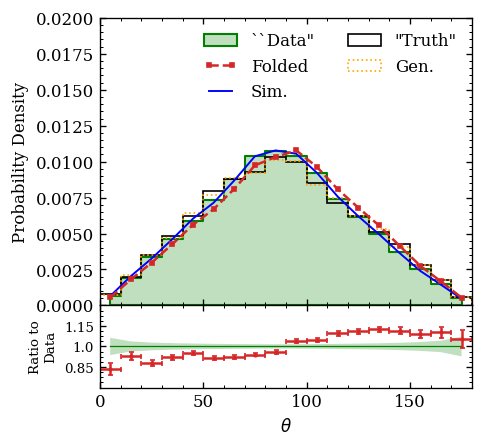

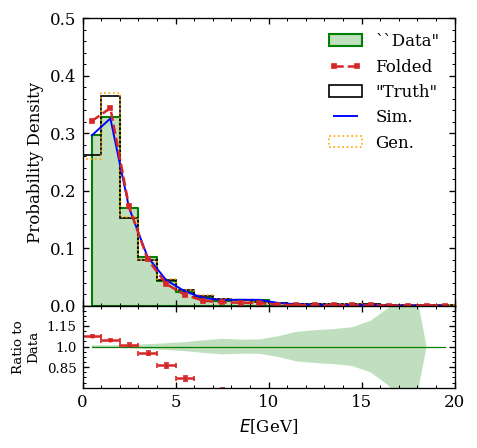

In [157]:
plot_directory  = "./plots/"

for i,(obkey,ob) in enumerate(obs.items()):


    # get the styled axes on which to plot
    ob['ylabel_ratio']='Ratio to\nData'
    fig, [ax0, ax1] = modplot.axes(**ob)
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])

        
    # Plot the Different Distributions of the Observable
    # plot the "data" histogram of the observable
    
    ax0.hist(ob['truthobs'], bins=ob['bins_det'], color='black', label='\"Truth\"', **hist_style)


    # plot the "sim" histogram of the observable
    ax0.hist(ob['genobs'], bins=ob['bins_det'], color='orange', label='Gen.', **hist_style, linestyle = 'dotted')

    # plot the "gen" histogram of the observable
    ax0.plot(ob['midbins_mc'], ob['simobs_hist'], **gen_style)

    # plot the "truth" histogram of the observable
    ax0.fill_between(ob['midbins_mc'], ob['data_hist'], **truth_style)

    
    # Plot the Unfolded Distributions of the Observable
    # plot the OmniFold distribution
    of_histgen, of_histgen_unc = modplot.calc_hist(ob['simobs'], 
                                                   weights=multifold_ws[-1], 
                                                   bins=ob['bins_mc'], density=True)[:2]
    
    ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label='Folded')

    # plot the IBU distribution
    #ax0.plot(ob['midbins_mc'], ob['ibu_phis'][itnum], **ibu_style, label='IBU ' + ob['symbol'])

    # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
    # ibu_ratio = ob['ibu_phis'][itnum]/(ob['truth_hist'] + 10**-50)
    of_ratio = of_histgen/(ob['data_hist'] + 10**-50)
    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['data_hist_unc']/(ob['data_hist'] + 10**-50)
    #ibu_unc_ratio = ob['ibu_phi_unc']/(ob['truth_hist'] + 10**-50)
    of_unc_ratio = of_histgen_unc/(ob['data_hist'] + 10**-50)
    
    ax1.fill_between(ob['midbins_mc'], 1 - truth_unc_ratio, 1 + truth_unc_ratio, 
                     facecolor=truth_style['facecolor'], zorder=-2)
    #ax1.errorbar(ob['midbins_mc'], ibu_ratio, xerr=ob['binwidth_mc']/2, yerr=ibu_unc_ratio, 
                                              #color=ibu_style['color'], **modplot.style('errorbar'))
    ax1.errorbar(ob['midbins_mc'], of_ratio, xerr=ob['binwidth_mc']/2, yerr=of_unc_ratio, 
                                              color=omnifold_style['color'], **modplot.style('errorbar'))

    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [3, 4, 2, 0, 1] if ncol==2 else [3, 4, 0, 2, 1]
    modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol)


    # save plot.
    fig.savefig(plot_directory + 'MultiFold_{}.pdf'.format(obkey), bbox_inches='tight')  

In [158]:
weight_dic = {'weight': multifold_ws[-2]}
sim.update(weight_dic)
# print(sim['weight'][sim['weight']>1.05])
print(sim['weight'].sum())
# output = pd.DataFrame()
# df_dictionary = pd.DataFrame([weight_dic])
# output = data.assign(weight=multifold_ws[2*itnum])

43775.07888330734


In [159]:
weight_dic['weight']

array([0.37404912, 0.69284961, 0.75829823, ..., 0.54288767, 0.68167088,
       0.67428306])

In [160]:
# import importlib
# importlib.reload(omnifold)

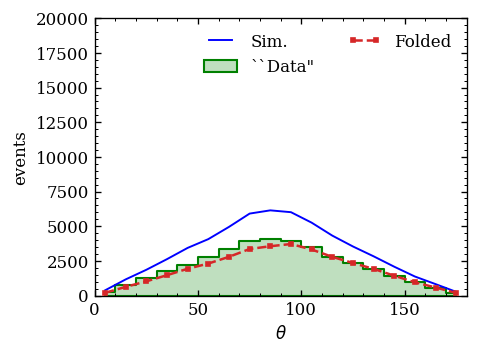

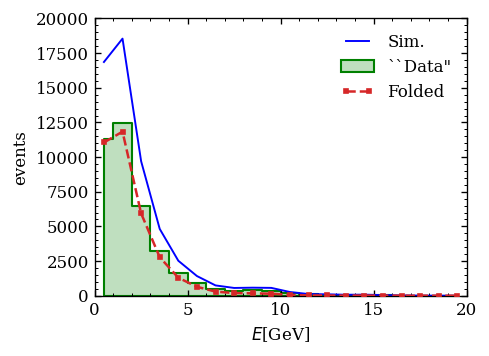

In [161]:
for i,(obkey,ob) in enumerate(obs.items()):

    ob['ylabel'] = 'events'
    ob['ylim'] = (0, 20000)
    ob['figsize'] = (4,3)
#     print(ob)
    fig, [ax0] = modplot.axes(ratio_plot=False, **ob)
#     if ob.get('yscale') is not None:
#     ax0.set_ylim([0,20000])
    ob['simobs_hist_o'] = np.histogram(ob['simobs'], bins=ob['bins_mc'], density=False)[0]
    ob['data_hist_o'], ob['data_hist_unc_o'] = modplot.calc_hist(ob['dataobs'],
                                                               bins=ob['bins_mc'], density=False)[:2]    
    ax0.plot(ob['midbins_mc'], ob['simobs_hist_o'], **gen_style)

    ax0.fill_between(ob['midbins_mc'], ob['data_hist_o'], **truth_style)
    ob['simobs_hist_w'] = np.histogram(ob['simobs'], bins=ob['bins_mc'], weights=multifold_ws[-1], density=False)[0]
    ax0.plot(ob['midbins_mc'], ob['simobs_hist_w'], **omnifold_style, label='Folded')


    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [0, 1, 2] 
    modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol)


In [136]:
test = np.load('./Test.npy')

In [111]:
test

array([[0.66666667, 0.66666667, 0.66666667, ..., 0.66666667, 0.66666667,
        0.66666667],
       [0.88881135, 0.61499329, 0.58658961, ..., 0.72579988, 0.63911406,
        0.57276122],
       [0.92415786, 0.72337937, 0.82172259, ..., 0.84047969, 1.01489107,
        0.70089912],
       ...,
       [0.87742065, 0.64444261, 0.67320445, ..., 0.77206827, 0.82311826,
        0.59131901],
       [0.25531425, 0.59117785, 0.57757008, ..., 0.48482327, 0.59664959,
        0.5146084 ],
       [0.72674279, 0.47182859, 0.50323694, ..., 0.6727444 , 0.56678148,
        0.43999637]])